# Module 2, Section 2: Eval-Driven Development

Our baseline evaluation revealed weaknesses in the current database sub-agent:

**The Problem:**
- ❌ **Excessive tool calls**: Sequential chains of `get_order_items` → multiple `get_product_info` calls
- ❌ **Missing capabilities**: Can't aggregate (SUM, COUNT, AVG), filter (WHERE), or JOIN across tables
- ❌ **Limited flexibility**: Rigid tools can't adapt to complex queries

**The Solution:**
Build a flexible SQL agent that generates custom queries at runtime to answer any database question efficiently.

Let's use our evaluation results to drive a targeted improvement! 🎯

## 1. Setup

We'll build a SQL agent that can generate custom queries to answer complex database questions.


In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [35]:
from config import get_techhub_runtime_context

runtime_context = get_techhub_runtime_context(with_vectorstore=True)


# Extract schema once - we'll inject this into the agent's system prompt
table_info = runtime_context.db.get_table_info()

## 2. Build SQL Agent

We'll create a tool that executes SQL queries and an agent that can generate those queries on-demand using `create_agent()` abstraction.


In [22]:
from langchain.tools import tool, ToolRuntime


@tool
def execute_sql(query: str, runtime: ToolRuntime) -> str:
    """Execute a SELECT query against the TechHub database.

    Safety: Only SELECT queries allowed - no INSERT/UPDATE/DELETE/etc.
    """
    # Safety check: Only allow SELECT queries
    if not query.strip().upper().startswith("SELECT"):
        return "Error: Only SELECT queries are allowed."

    # Block dangerous keywords
    FORBIDDEN = [
        "INSERT",
        "UPDATE",
        "DELETE",
        "ALTER",
        "DROP",
        "CREATE",
        "REPLACE",
        "TRUNCATE",
    ]
    if any(keyword in query.upper() for keyword in FORBIDDEN):
        return "Error: Query contains forbidden keyword."

    # Execute query
    db = runtime.context.db
    try:
        result = db._execute(query)
        result = [tuple(row.values()) for row in result]  # extract values
        return result
    except Exception as e:
        return f"SQL Error: {str(e)}"

In [23]:
SQL_AGENT_SYSTEM_PROMPT = f"""You are a database specialist for TechHub customer support.

You have access to a SQLite database with the following schema:

{table_info}

Your capabilities:
- Write SQL SELECT queries to answer any database question
- Use JOINs, aggregations (SUM, COUNT, AVG), filtering (WHERE), GROUP BY, ORDER BY
- Handle complex queries with multiple conditions

Guidelines:
1. Only use SELECT queries (read-only access)
2. Use proper JOINs when querying related tables
3. Format currency as $X.XX in your final answer
4. Provide context, not just raw numbers
5. If a query returns no results, explain why

Important: Read-only access - no INSERT/UPDATE/DELETE operations."""

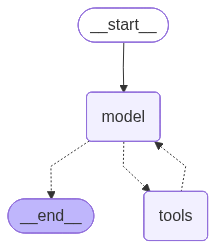

In [24]:
from langchain.agents import create_agent
from config import DEFAULT_MODEL

sql_agent = create_agent(
    model=DEFAULT_MODEL,
    tools=[execute_sql],
    system_prompt=SQL_AGENT_SYSTEM_PROMPT,
)
sql_agent

## 3. Quick Demo

Let's test the SQL agent on a query that previously failed in our baseline evaluation.


In [25]:
# Test on a query that requires aggregation (previously failed)
question = (
    "How much have I spent on keyboards in total? My email is it.purchasing@finance.com"
)

result = sql_agent.invoke(
    {"messages": [{"role": "user", "content": question}]},
    context=runtime_context,
)

for message in result["messages"]:
    message.pretty_print()

/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=RuntimeContext(db=<langch..., policy_retriever=None), input_type=RuntimeContext])
  return self.__pydantic_serializer__.to_python(


================================ Human Message =================================

How much have I spent on keyboards in total? My email is it.purchasing@finance.com
================================== Ai Message ==================================

[{'text': "I'll help you find your total spending on keyboards. Let me query the database with your email address.", 'type': 'text'}, {'id': 'toolu_012vbP5XhezLxKgiLUoRT2iH', 'input': {'query': "\nSELECT \n    SUM(oi.quantity * oi.price_per_unit) as total_spent\nFROM customers c\nJOIN orders o ON c.customer_id = o.customer_id\nJOIN order_items oi ON o.order_id = oi.order_id\nJOIN products p ON oi.product_id = p.product_id\nWHERE c.email = 'it.purchasing@finance.com'\nAND p.category = 'Keyboards'\n"}, 'name': 'execute_sql', 'type': 'tool_use'}]
Tool Calls:
  execute_sql (toolu_012vbP5XhezLxKgiLUoRT2iH)
 Call ID: toolu_012vbP5XhezLxKgiLUoRT2iH
  Args:
    query: 
SELECT 
    SUM(oi.quantity * oi.price_per_unit) as total_spent
FROM customers c
JO

✅ **Success!** The SQL agent generates a custom query with JOINs and aggregation to answer the question efficiently in just a single tool call.

Check the LangSmith trace to see the generated SQL query!


## 4. Integrate SQL Agent with Supervisor HITL

Now let's swap our old rigid DB agent with this flexible SQL agent in the full supervisor HITL system.


In [40]:
from agents.docs_agent import create_docs_agent
from agents.sql_agent import create_sql_agent
from agents.supervisor_hitl_agent import CustomState, create_supervisor_hitl_agent

# Instantiate improved SQL agent for deployment
sql_agent = create_sql_agent(
    state_schema=CustomState,
)

# Instantiate docs agent
docs_agent = create_docs_agent()

# Module-level graph instance for deployment
# Compose supervisor HITL with SQL agent instead of db_agent
improved_agent = create_supervisor_hitl_agent(
    db_agent=sql_agent,
    docs_agent=docs_agent,
)

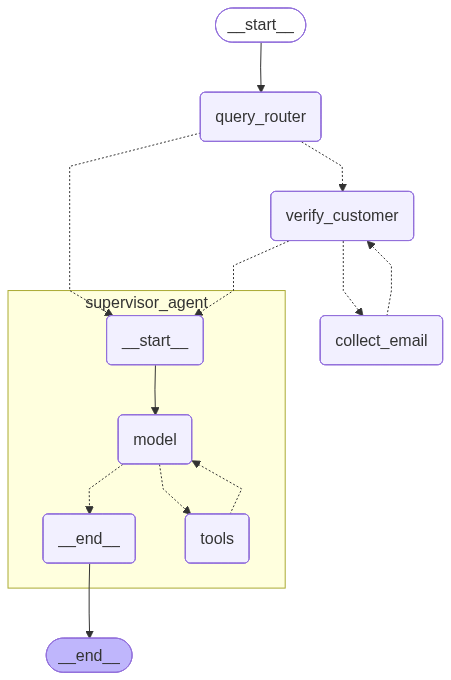

In [41]:
from IPython.display import Image

display(Image(improved_agent.get_graph(xray=True).draw_mermaid_png()))

In [44]:
import uuid
from langgraph.types import Command

# New thread
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}

# First invocation - will pause at interrupt
result = improved_agent.invoke(
    {"messages": [{"role": "user", "content": "Whats the status of my recent order?"}]},
    config=config,
    context=runtime_context,
)

result

/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=RuntimeContext(db=<langch...mbda> at 0x30b0872e0>})), input_type=RuntimeContext])
  return self.__pydantic_serializer__.to_python(


{'messages': [HumanMessage(content="Hi, I'm Priya Patel (priya.patel@icloud.com). I need a report breaking down all of my past orders and what was in each. Can you help?", additional_kwargs={}, response_metadata={}, id='e6b4046c-f5a6-4f28-9818-7e7a49d96f27'),
  AIMessage(content='✓ Verified! Welcome back, Priya Patel.', additional_kwargs={}, response_metadata={}, id='312eae0f-4083-4c9f-9b43-b886d6f5b796'),
  AIMessage(content=[{'text': "\n\nI'll retrieve a detailed breakdown of all your past orders for you.", 'type': 'text'}, {'id': 'toolu_01UvGpdsNqDCMHGzxRpBdbBu', 'input': {'query': 'Retrieve all past orders for this customer with complete order details including items, quantities, and descriptions for each order'}, 'name': 'database_specialist', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_014Qr7Pi3xtSYRzi9UqwY7rx', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tok

In [31]:
# Resume with valid email
result = improved_agent.invoke(
    Command(resume="Ok, its: sarah.chen@gmail.com"),
    config=config,
    context=runtime_context,
)
result

/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=RuntimeContext(db=<langch..., policy_retriever=None), input_type=RuntimeContext])
  return self.__pydantic_serializer__.to_python(


{'messages': [HumanMessage(content='Whats the status of my recent order?', additional_kwargs={}, response_metadata={}, id='8bc3404c-ce1a-4772-ad19-7de0235089f9'),
  AIMessage(content='To access information about your account or orders, please provide your email address.', additional_kwargs={}, response_metadata={}, id='89e05f20-25f1-45b0-b42c-195aa8aa782a'),
  HumanMessage(content='Ok, its: sarah.chen@gmail.com', additional_kwargs={}, response_metadata={}, id='ac524b43-5bad-490c-b621-5fa354c0a7f3'),
  AIMessage(content='✓ Verified! Welcome back, Sarah Chen.', additional_kwargs={}, response_metadata={}, id='bc7a6413-bfaf-4955-9a70-c14ccc5cc492'),
  AIMessage(content=[{'text': '\n\nLet me retrieve the status of your recent order.', 'type': 'text'}, {'id': 'toolu_01KoQpdUCR1Ub7mFg4cDewke', 'input': {'query': "What is the status of the customer's most recent order?"}, 'name': 'database_specialist', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01PDEo2WE5CZYEs47t

In [32]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Whats the status of my recent order?
================================== Ai Message ==================================

To access information about your account or orders, please provide your email address.
================================ Human Message =================================

Ok, its: sarah.chen@gmail.com
================================== Ai Message ==================================

✓ Verified! Welcome back, Sarah Chen.
================================== Ai Message ==================================

[{'text': '\n\nLet me retrieve the status of your recent order.', 'type': 'text'}, {'id': 'toolu_01KoQpdUCR1Ub7mFg4cDewke', 'input': {'query': "What is the status of the customer's most recent order?"}, 'name': 'database_specialist', 'type': 'tool_use'}]
Tool Calls:
  database_specialist (toolu_01KoQpdUCR1Ub7mFg4cDewke)
 Call ID: toolu_01KoQpdUCR1Ub7mFg4cDewke
  Args:
    query: What is the stat

## 5. Re-evaluate Performance

Now let's run the same evaluation on the same dataset to measure improvement.


In [42]:
# Import evaluators from Section 1 (now packaged in evaluators module)
# In Section 1, we built these evaluators from scratch to learn how they work.
# Now we can simply import and reuse them - same pattern as agents!
from evaluators import correctness_evaluator, count_total_tool_calls_evaluator

In [43]:
import uuid
from langsmith import Client

client = Client()


def improved_target_function(inputs: dict) -> dict:
    """Target function that wraps our improved agent for evaluation."""
    thread_id = uuid.uuid4()
    config = {"configurable": {"thread_id": thread_id}}

    result = improved_agent.invoke(
        inputs,
        config=config,
        context=runtime_context,
    )
    return {
        "messages": [{"role": "assistant", "content": result["messages"][-1].content}]
    }


# Run evaluation on same dataset
results = client.evaluate(
    improved_target_function,
    data="techhub-baseline-evaluation",  # Same dataset as section 1
    evaluators=[correctness_evaluator, count_total_tool_calls_evaluator],
    experiment_prefix="improved-with-sql-agent",
    description="Evaluate SQL agent's flexible query generation vs baseline rigid tools",
    max_concurrency=5,
)

View the evaluation results for experiment: 'improved-with-sql-agent-b0c38638' at:
https://smith.langchain.com/o/5aa54808-d164-4ed7-bc4d-e5630f7ffd37/datasets/8a1d4378-6f53-43d4-bae3-5bbba3d3c03b/compare?selectedSessions=102e372b-0ef6-4f65-b57a-1caa771adb2f




0it [00:00, ?it/s]

/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=RuntimeContext(db=<langch...mbda> at 0x30b0872e0>})), input_type=RuntimeContext])
  return self.__pydantic_serializer__.to_python(


Exception in thread Thread-45 (bg_main):
Traceback (most recent call last):
  File "/var/folders/6c/8vvt_b951vg7m1nzx6rqyf380000gn/T/ipykernel_88019/268895996.py", line 17, in bg_main
    output.update({"application/vnd.vscode.bg.execution.31.result": do_implementation()}, raw=True)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/IPython/core/display_functions.py", line 354, in update
    update_display(obj, display_id=self.display_id, **kwargs)
    ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/IPython/core/display_functions.py", line 306, in update_display
    display(obj, display_id=display_id, **kwargs)
    ~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andrew.reed/Documents/workshops/lc-enablement-w

## 6. Compare Results in LangSmith

Now let's analyze our improvement using LangSmith's comparison features.

### Steps to Compare:

1. **Navigate to Datasets & Experiments** in LangSmith
2. **Select both experiments:**
   - `baseline-eval-XXXXX` (from Section 1)
   - `improved-with-sql-agent-XXXXX` (from this section)
3. **Click "Compare"** to see side-by-side metrics
4. **Filter by previously failed examples** to see specific improvements
5. **Click into traces** to see:
   - Baseline: Multiple sequential tool calls
   - Improved: Single SQL query with JOINs/aggregations

### Expected Improvements:

**Correctness:**
- Baseline: ~50% (rigid tools couldn't answer complex queries)
- Improved: ~90%+ (SQL agent handles aggregations, filters, JOINs)

**Tool Call Efficiency:**
- Baseline: 5-20+ sequential tool calls for complex queries
- Improved: 1-2 tool calls with efficient SQL

### Key Insight:

By replacing rigid tools with flexible SQL generation, we've:
- ✅ Increased correctness by ~40 percentage points
- ✅ Reduced tool calls by 80-90%
- ✅ Enabled new capabilities (aggregations, filtering, complex JOINs)

This is **eval-driven development** in action: measure → analyze → improve → measure again! 🎯
